In [ ]:
!nvidia-smi

Thu Apr 24 15:30:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   77C    P0             30W /   70W |    9612MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence

In [ ]:
torch.cuda.is_available()

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/DEPI_Project

/content/drive/MyDrive/DEPI_Project


In [ ]:
!pwd

/content/drive/MyDrive/DEPI_Project


In [ ]:
FEATURE_DIR = "/content/drive/MyDrive/DEPI_Project/featured_extracted/cv-other-dev"  # Update this
CSV_PATH = "/content/drive/MyDrive/DEPI_Project/mel_processed_dataset.csv"  # Update this

In [ ]:
class Config:
    """Configuration for the audio transcription model"""
    # Data paths
    feature_dir = FEATURE_DIR  # Update this path
    csv_path = CSV_PATH  # CSV file with mappings

    # Text processing
    vocab = list("abcdefghijklmnopqrstuvwxyz' ")  # Character vocabulary
    char_to_idx = {char: idx for idx, char in enumerate(vocab)}
    idx_to_char = {idx: char for idx, char in enumerate(vocab)}
    vocab_size = len(vocab)

    # Feature dimensions
    feature_dim = 128  # Update this to match your feature dimensions

    # Model parameters
    hidden_size = 512
    num_layers = 3
    bidirectional = True
    dropout = 0.2

    # Training parameters
    batch_size = 64
    learning_rate = 0.0005
    num_epochs = 50

    # Device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class AudioFeatureDataset(Dataset):
    def __init__(self, csv_path, config, train=True):
        self.config = config

        # Load mappings from CSV file
        self.df = pd.read_csv(csv_path)

        # Ensure feature path column and transcript column exist
        if 'feature_path' not in self.df.columns or 'transcript' not in self.df.columns:
            raise ValueError("CSV file must contain 'feature_path' and 'transcript' columns")

        # Data split
        if train:
            self.df = self.df.sample(frac=0.8, random_state=42)
        else:
            all_df = pd.read_csv(csv_path)
            train_df = all_df.sample(frac=0.8, random_state=42)
            self.df = all_df[~all_df.index.isin(train_df.index)]

        # Validate that all feature files exist
        valid_rows = []
        for idx, row in self.df.iterrows():
            feature_path = row['feature_path']
            if os.path.exists(feature_path):
                valid_rows.append(row)
            else:
                print(f"Warning: Feature file not found: {feature_path}")

        if valid_rows:
            self.df = pd.DataFrame(valid_rows).reset_index(drop=True)
            print(f"Dataset loaded with {len(self.df)} valid samples")
        else:
            raise ValueError("No valid feature files found. Check your feature paths in the CSV file.")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        feature_path = self.df.iloc[idx]['feature_path']
        transcript = str(self.df.iloc[idx]['transcript']).lower()

        features = np.load(feature_path)
        features = torch.tensor(features, dtype=torch.float32)

        if len(features.shape) == 2:
            if features.shape[0] > features.shape[1]:
                pass
            else:
                features = features.transpose(0, 1)
        else:
            raise ValueError(f"Unexpected feature shape: {features.shape}")

        if features.shape[1] != self.config.feature_dim:
            if features.shape[1] > self.config.feature_dim:
                features = features[:, :self.config.feature_dim]
            else:
                padding = torch.zeros(features.shape[0], self.config.feature_dim - features.shape[1])
                features = torch.cat([features, padding], dim=1)

        text_indices = [self.config.char_to_idx[c] for c in transcript if c in self.config.char_to_idx]
        text_indices = torch.tensor(text_indices, dtype=torch.long)

        return features, text_indices, features.shape[0], len(text_indices)

In [ ]:
def collate_fn(batch):
    batch.sort(key=lambda x: x[2], reverse=True)
    features, text_indices, feature_lengths, text_lengths = zip(*batch)

    features_padded = pad_sequence(features, batch_first=True)
    text_padded = pad_sequence(text_indices, batch_first=True)

    feature_lengths = torch.tensor(feature_lengths)
    text_lengths = torch.tensor(text_lengths)

    return features_padded, text_padded, feature_lengths, text_lengths

In [ ]:
class AudioEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, bidirectional, dropout):
        super(AudioEncoder, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        self.output_dim = hidden_dim * 2 if bidirectional else hidden_dim

    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths, batch_first=True, enforce_sorted=True
        )

        outputs, _ = self.lstm(packed)
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)

        return outputs

In [ ]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim):
        super(Attention, self).__init__()
        self.encoder_attn = nn.Linear(encoder_dim, decoder_dim)
        self.decoder_attn = nn.Linear(decoder_dim, decoder_dim)
        self.full_attn = nn.Linear(decoder_dim, 1)

    def forward(self, decoder_hidden, encoder_outputs):
        # Ensure decoder_hidden is properly shaped
        if len(decoder_hidden.shape) == 1:
            decoder_hidden = decoder_hidden.unsqueeze(0)

        # Transform encoder outputs [batch_size, seq_len, encoder_dim] -> [batch_size, seq_len, decoder_dim]
        encoder_transform = self.encoder_attn(encoder_outputs)

        # Transform decoder hidden [batch_size, decoder_dim] -> [batch_size, 1, decoder_dim]
        decoder_transform = self.decoder_attn(decoder_hidden).unsqueeze(1)

        # Calculate attention scores
        attn_scores = self.full_attn(torch.tanh(encoder_transform + decoder_transform))

        # Get attention weights through softmax
        attn_weights = torch.softmax(attn_scores, dim=1)

        # Use weights to get context vector [batch_size, 1, encoder_dim]
        context = torch.bmm(attn_weights.transpose(1, 2), encoder_outputs)

        return context.squeeze(1), attn_weights

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, hidden_dim, encoder_dim, num_layers, dropout):
        super(DecoderRNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.lstm = nn.LSTM(
            input_size=hidden_dim + encoder_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        self.attention = Attention(encoder_dim, hidden_dim)
        self.output_projection = nn.Linear(hidden_dim + encoder_dim, vocab_size)
        self.hidden_dim = hidden_dim
        self.encoder_dim = encoder_dim

    def forward_step(self, decoder_input, decoder_hidden, encoder_outputs):
        # Ensure decoder_input has proper dimensions [batch_size, 1]
        if len(decoder_input.shape) == 1:
            decoder_input = decoder_input.unsqueeze(1)

        # Get embeddings [batch_size, 1, hidden_dim]
        embedded = self.embedding(decoder_input)

        # Get context vector and attention weights
        context, attention_weights = self.attention(decoder_hidden[0][-1], encoder_outputs)

        # Ensure context has shape [batch_size, 1, encoder_dim]
        if len(context.shape) == 2:
            context = context.unsqueeze(1)

        # Concatenate embedded input and context vector along the feature dimension
        lstm_input = torch.cat([embedded, context], dim=-1)  # Use dim=-1 instead of dim=2

        # Forward through LSTM
        output, hidden = self.lstm(lstm_input, decoder_hidden)

        # Concatenate output and context for prediction
        output_context = torch.cat([output, context], dim=-1)  # Use dim=-1 here too
        output = self.output_projection(output_context)

        return output, hidden, attention_weights

    def init_hidden(self, batch_size):
        h0 = torch.zeros(self.lstm.num_layers, batch_size, self.hidden_dim).to(next(self.parameters()).device)
        c0 = torch.zeros(self.lstm.num_layers, batch_size, self.hidden_dim).to(next(self.parameters()).device)
        return (h0, c0)

In [ ]:
class Seq2SeqModel(nn.Module):
    def __init__(self, config):
        super(Seq2SeqModel, self).__init__()

        self.encoder = AudioEncoder(
            input_dim=config.feature_dim,
            hidden_dim=config.hidden_size,
            num_layers=config.num_layers,
            bidirectional=config.bidirectional,
            dropout=config.dropout
        )

        encoder_dim = config.hidden_size * 2 if config.bidirectional else config.hidden_size

        self.decoder = DecoderRNN(
            vocab_size=config.vocab_size,
            hidden_dim=config.hidden_size,
            encoder_dim=encoder_dim,
            num_layers=config.num_layers,
            dropout=config.dropout
        )

        self.config = config

    def forward(self, features, target_texts, feature_lengths, text_lengths, teacher_forcing_ratio=0.5):
        batch_size = features.size(0)
        max_text_length = target_texts.size(1)

        encoder_outputs = self.encoder(features, feature_lengths)
        decoder_hidden = self.decoder.init_hidden(batch_size)
        decoder_input = torch.ones(batch_size, 1, dtype=torch.long, device=self.config.device) * 0  # Start token

        outputs = torch.zeros(batch_size, max_text_length, self.config.vocab_size, device=self.config.device)

        for t in range(max_text_length):
            output, decoder_hidden, _ = self.decoder.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )

            outputs[:, t:t+1] = output

            use_teacher_forcing = torch.rand(1).item() < teacher_forcing_ratio

            if use_teacher_forcing and t < max_text_length - 1:
                decoder_input = target_texts[:, t:t+1]
            else:
                _, topi = output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        return outputs

    def predict(self, features, feature_lengths):
        batch_size = features.size(0)
        max_text_length = 100  # Limit max length for prediction

        encoder_outputs = self.encoder(features, feature_lengths)
        decoder_hidden = self.decoder.init_hidden(batch_size)
        decoder_input = torch.ones(batch_size, 1, dtype=torch.long, device=self.config.device) * 0  # Start token

        predicted_indices = []
        attention_weights_list = []

        for t in range(max_text_length):
            output, decoder_hidden, attention_weights = self.decoder.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )

            # Get the most likely next token
            _, topi = output.max(2)

            # For a batch size of 1, get the scalar value
            if batch_size == 1:
                predicted_idx = topi.item()
            else:
                predicted_idx = topi.squeeze().cpu().numpy()

            # Save prediction and attention weights
            predicted_indices.append(predicted_idx)
            attention_weights_list.append(attention_weights)

            # Prepare next input
            decoder_input = topi.detach()

            # Stop if EOS token is predicted (for batch size 1)
            if batch_size == 1 and predicted_idx == 1:  # Assuming 1 is your EOS token
                break

        return predicted_indices, attention_weights_list

In [ ]:
def train(model, train_loader, criterion, optimizer, device, epoch, clip=5.0):
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}")

    for batch_idx, (features, target_texts, feature_lengths, text_lengths) in enumerate(progress_bar):
        # Move data to device
        features = features.to(device)
        target_texts = target_texts.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(features, target_texts, feature_lengths, text_lengths)

        # Calculate loss - use masks for variable length sequences
        mask = torch.zeros_like(target_texts, dtype=torch.bool)
        for i, length in enumerate(text_lengths):
            mask[i, :length] = 1

        # Reshape outputs and targets for loss calculation
        outputs = outputs.view(-1, outputs.size(-1))
        target_texts = target_texts.view(-1)
        mask = mask.view(-1)

        # Apply mask
        outputs = outputs[mask]
        target_texts = target_texts[mask]

        # Calculate loss
        loss = criterion(outputs, target_texts)

        # Backward pass
        loss.backward()

        # Clip gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        # Update parameters
        optimizer.step()

        # Update total loss
        total_loss += loss.item()

        # Update progress bar
        progress_bar.set_postfix({"loss": loss.item()})

    return total_loss / len(train_loader)

In [ ]:
def evaluate(model, eval_loader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for features, target_texts, feature_lengths, text_lengths in tqdm(eval_loader, desc="Evaluating"):
            # Move data to device
            features = features.to(device)
            target_texts = target_texts.to(device)

            # Forward pass
            outputs = model(features, target_texts, feature_lengths, text_lengths, teacher_forcing_ratio=0)

            # Calculate loss with masking
            mask = torch.zeros_like(target_texts, dtype=torch.bool)
            for i, length in enumerate(text_lengths):
                mask[i, :length] = 1

            outputs = outputs.view(-1, outputs.size(-1))
            target_texts = target_texts.view(-1)
            mask = mask.view(-1)

            outputs = outputs[mask]
            target_texts = target_texts[mask]

            loss = criterion(outputs, target_texts)
            total_loss += loss.item()

    return total_loss / len(eval_loader)

In [ ]:
def transcribe(model, feature_path, config):
    """Transcribe using pre-extracted features from a file"""
    model.eval()

    # Load pre-extracted features
    features = np.load(feature_path)
    features = torch.tensor(features, dtype=torch.float32)

    # Handle different feature shapes - ensure features are [time, feature_dim]
    if len(features.shape) == 2:
        if features.shape[0] > features.shape[1]:
            # Already in [time, feature_dim] format
            pass
        else:
            # Convert from [feature_dim, time] to [time, feature_dim]
            features = features.transpose(0, 1)
    else:
        raise ValueError(f"Unexpected feature shape: {features.shape}")

    # Prepare for model
    feature_length = features.shape[0]
    features = features.unsqueeze(0).to(config.device)  # Add batch dimension

    with torch.no_grad():
        # Predict
        predictions, attention_weights = model.predict(features, torch.tensor([feature_length]))

    # Convert indices to text
    transcription = ""
    for idx in predictions:  # predictions is now a list of integers
        if idx == 1:  # Stop token
            break
        if idx in config.idx_to_char:
            transcription += config.idx_to_char[idx]

    return transcription, attention_weights

In [ ]:
# Add this function before your main() function
def early_stopping(val_losses, patience=5):
    """
    Check if training should stop early based on validation loss plateau
    Returns True if training should stop, False otherwise
    """
    # Need at least patience+1 epochs of validation data
    if len(val_losses) <= patience:
        return False

    # Check if validation loss hasn't improved for the last 'patience' epochs
    best_loss_idx = val_losses.index(min(val_losses))
    return len(val_losses) - best_loss_idx > patience

In [ ]:
def main():
    # Initialize config
    config = Config()

    # Create datasets and dataloaders
    train_dataset = AudioFeatureDataset(
        csv_path=config.csv_path,
        config=config,
        train=True
    )

    val_dataset = AudioFeatureDataset(
        csv_path=config.csv_path,
        config=config,
        train=False
    )

    # Before creating DataLoader, print a few samples' feature shape
    print(f"Expected feature dimension: {config.feature_dim}")

    # Sample a few entries to verify dimensions
    for i in range(5):
        features, _, _, _ = train_dataset[i]
        print(f"Sample {i} feature shape: {features.shape}")

    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        collate_fn=collate_fn
    )

    # Print dataset statistics
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")


    # Initialize model
    model = Seq2SeqModel(config).to(config.device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )

    # Training loop
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    no_improvement_count = 0
    early_stop_patience = 5

    for epoch in range(1, config.num_epochs + 1):
        # Train
        train_loss = train(model, train_loader, criterion, optimizer, config.device, epoch)
        train_losses.append(train_loss)

        # Evaluate
        val_loss = evaluate(model, val_loader, criterion, config.device)
        val_losses.append(val_loss)

        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_count = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'config': {
                    'feature_dim': config.feature_dim,
                    'hidden_size': config.hidden_size,
                    'num_layers': config.num_layers,
                    'bidirectional': config.bidirectional,
                    'dropout': config.dropout,
                    'vocab_size': config.vocab_size,
                    'char_to_idx': config.char_to_idx,
                    'idx_to_char': config.idx_to_char
                }
            }, 'best_audio_transcription_model.pth')
        else:
            no_improvement_count += 1

        # Early stopping check
        if no_improvement_count >= early_stop_patience:
            print(f"Early stopping triggered after {epoch} epochs (no improvement for {early_stop_patience} epochs)")
            break

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.savefig('training_history.png')

    # Test the model on a few samples
    print("\nTesting model on a few examples:")
    for i in range(min(5, len(val_dataset))):
        feature_path = val_dataset.df.iloc[i]['feature_path']
        true_transcription = val_dataset.df.iloc[i]['transcript']

        pred_transcription, _ = transcribe(model, feature_path, config)

        print(f"\nSample {i+1}: {os.path.basename(feature_path)}")
        print(f"True: {true_transcription}")
        print(f"Pred: {pred_transcription}")


In [ ]:
def load_and_use_model(model_path, feature_path):
    """Load a trained model and use it to transcribe audio"""
    # Load the saved model
    checkpoint = torch.load(model_path)

    # Create a config from the saved parameters
    config = Config()
    config.feature_dim = checkpoint['config']['feature_dim']
    config.hidden_size = checkpoint['config']['hidden_size']
    config.num_layers = checkpoint['config']['num_layers']
    config.bidirectional = checkpoint['config']['bidirectional']
    config.dropout = checkpoint['config']['dropout']
    config.vocab_size = checkpoint['config']['vocab_size']
    config.char_to_idx = checkpoint['config']['char_to_idx']
    config.idx_to_char = checkpoint['config']['idx_to_char']

    # Initialize model
    model = Seq2SeqModel(config).to(config.device)

    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])

    # Set to evaluation mode
    model.eval()

    # Transcribe
    transcription, _ = transcribe(model, feature_path, config)

    return transcription

In [ ]:
torch.cuda.empty_cache()

Dataset loaded with 2404 valid samples
Dataset loaded with 601 valid samples
Expected feature dimension: 128
Sample 0 feature shape: torch.Size([128, 128])
Sample 1 feature shape: torch.Size([128, 128])
Sample 2 feature shape: torch.Size([128, 128])
Sample 3 feature shape: torch.Size([128, 128])
Sample 4 feature shape: torch.Size([128, 128])
Training samples: 2404
Validation samples: 601


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Evaluating: 100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


Epoch 1: Train Loss = 2.9120, Val Loss = 2.8859


Evaluating: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Epoch 2: Train Loss = 2.7641, Val Loss = 2.8764


Evaluating: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Epoch 3: Train Loss = 2.6565, Val Loss = 3.0121


Evaluating: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Epoch 4: Train Loss = 2.5699, Val Loss = 3.0236


Evaluating: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Epoch 5: Train Loss = 2.5399, Val Loss = 2.9856


Evaluating: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Epoch 6: Train Loss = 2.5098, Val Loss = 2.9216


Evaluating: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Epoch 7: Train Loss = 2.5033, Val Loss = 2.9499
Early stopping triggered after 7 epochs (no improvement for 5 epochs)

Testing model on a few examples:

Sample 1: sample-000001.npy
True: i could die happily and that made me feel good
Pred: ihe  oe   the  ore  the  ore  the  ore the  ore the  ore the  ore the  ore the  ore the  ore the  or

Sample 2: sample-000004.npy
True: are you going to live with your mother
Pred: ihe  oo   the  oo   the  oo   the  oo   the  oo   the  oo   the  oo   the  oo   the  oo   the  oo   

Sample 3: sample-000011.npy
True: the waitress was carrying an impressive amount of dinnerware but then an earthquake occurred and she dropped it all
Pred: ihe  oe   the  ore  the  ore the  ore the  ore the  ore the  ore the  ore the  ore the  ore the  ore

Sample 4: sample-000016.npy
True: how old are you
Pred: ihe  oo   the  oo   the  oo   the  oo   the  oo   the  oo   the  oo   the  oo   the  oo   the  oo   

Sample 5: sample-000019.npy
True: i was impatient to see it o

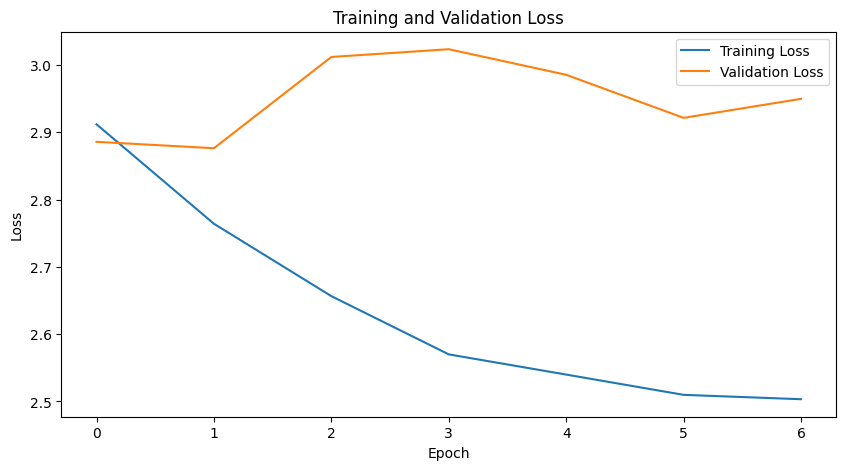

In [ ]:
if __name__ == "__main__":
    main()